# **Sketch Creation by Selecting Facial Features using CLIP guided StyleGAN3**

> -- by Nikhil Jawade, MSc AI with ML, ID: 210987533

> -- School of EECS, Queen Mary University of London, UK

> -- As Mini-Project for Computational Creativity

In [ ]:
#@markdown #**Check the type of GPU**

# @markdown Factory reset runtime if you don't have the desired GPU.

#@markdown ---
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-caf3973f-1717-1d54-e577-3354b267a632)


In [ ]:
#@markdown #**Installing required libraries**
# @markdown This cell will take a little while because it has to download several libraries.

#@markdown ---

!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja

import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan3')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 20.3 MB/s eta 0:01:00tcmalloc: large alloc 1147494400 bytes == 0x55ec44452000 @  0x7f6b35fa6615 0x55ec0af6a17c 0x55ec0b04a47a 0x55ec0af6cf9d 0x55ec0b05ed4d 0x55ec0afe0ec8 0x55ec0afdba2e 0x55ec0af6e88a 0x55ec0afe0d30 0x55ec0afdba2e 0x55ec0af6e88a 0x55ec0afdd719 0x55ec0b05fb76 0x55ec0afdcd95 0x55ec0b05fb76 0x55ec0afdcd95 0x55ec0b05fb76 0x55ec0afdcd95 0x55ec0af6ece9 0x55ec0afb2579 0x55ec0af6d902 0x55ec0afe0c4d 0x55ec0afdba2e 0x55ec0af6e88a 0x55ec0afdd719 0x55ec0afdba2e 0x55ec0af6e88a 0x55ec0afdc8f6 0x55ec0af6e7aa 0x55ec0afdcb4f 0x55ec0afdba2e
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:13:00tcmalloc: large alloc 1434370048 bytes == 0x55ec88aa8000 @  0x7f6b35fa6615 0x55ec0af6a17c 0x55ec0b04a47a 0x55ec0af6cf9d 0x55ec0b05ed4d 0x55ec0afe0ec8 0x55ec0afdba2e 0x55ec0af6e88a 0x55ec0afe0d30 0x55ec0afdba2e 0x55ec0af6e88a 0x55ec0afdd719 0x55ec0b05fb76 0x55ec0afdc

Using device: cuda:0


In [ ]:
#@markdown #**Necessary functions to execute the Program**

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path: 
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 113MiB/s]


In [ ]:
#@markdown #**Model Selection**

#@markdown **Here is the selection of our model**.

base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

Model = 'FFHQ' #@param ["FFHQ"]
#@markdown -- **FFHQ** is selected which is trained with human faces.

#@markdown ---

model_name = {"FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl"}

network_url = model_name[Model]

with open(fetch_model(network_url), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

--2022-04-18 11:15:13--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.89.154.4, 44.238.198.213
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.89.154.4|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl?response-content-disposition=attachment%3B%20filename%3D%22stylegan3-t-ffhqu-1024x1024.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjECsaCXVzLXdlc3QtMiJIMEYCIQCqNXCJ46a78%2FdCbfCOTK2uUAra3vefmC%2F7PaHdzkHPYwIhAIk0AzOmBicGR4Tds3FTkh4ZLNVMHbtYC95opwZfDI0KKoMECNT%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEQBBoMNzg5MzYzMTM1MDI3IgzUOoL9XOZeDUxf5KIq1wNrZv8HCmJ0J%2BjqTdyyBSsKmtCkbydqPyCLAlUIdMDNqgc1F9o%2FBifGTpBr6bmAMCcOBWdUd3rXHSZzfLkvzjsx9fcm%2Fjn9ctO

In [ ]:
#@title #**Run the model to generate images of Facial Features**

# @markdown This cell will take a little while.

#@markdown ---

# Here prompt is fixed to 'face'
texts = "face"

# seed was fixed to limited number of faces which matches dimensions decided for cropping the image
seed = [3, 6, 9, 10, 33, 37, 57, 85, 94, 102, 110, 113, 118, 121, 123, 131, 136, 139, 141, 147, 161, 177, 179, 195]

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]

# Actually do the run
tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

new_images = []

def run(timestring):
   for s in seed:
    torch.manual_seed(s)
    # Init
    # Sample 32 inits and choose the one closest to prompt
    with torch.no_grad():
      qs = []
      losses = []
      for _ in range(8):
        q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
        images = G.synthesis(q * w_stds + G.mapping.w_avg)
        embeds = embed_image(images.add(1).div(2))
        loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
        i = torch.argmin(loss)
        qs.append(q[i])
        losses.append(loss[i])
      qs = torch.stack(qs)
      losses = torch.stack(losses)
      i = torch.argmin(losses)
      q = qs[i].unsqueeze(0).requires_grad_()
    q_ema = q
    opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))    
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
    loss.backward()
    opt.step()
    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    temp_dict = { 'seed': s , 'image' : pil_image}
    new_images.append(temp_dict)

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


In [ ]:
#@markdown #**Necessary Functions to Display Images**

#@markdown ---

import random
forehead = []
eyes = []
nose = []
mouth = []

final_images = random.sample(new_images, k=15)

for i in final_images:
  pil_image = i['image']
  width, height = pil_image.size
  forehead.append(pil_image.crop((0, 200, 1024, 550)))
  eyes.append(pil_image.crop((0, 550, 1024, 725)))
  nose.append(pil_image.crop((0, 725, 1024, 875)))
  mouth.append(pil_image.crop((0, 875, 1024, 1000)))


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def display_grid(features):
  fig = plt.figure(figsize=(45, 20))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                  axes_pad=0.5,  # pad between axes in inch
                  )

  n = 1
  for ax, im in zip(grid, features):
      # Iterating over the grid returns the Axes.
      ax.set_title(n, fontsize=25)
      ax.imshow(im)
      ax.axis('off')
      n+=1

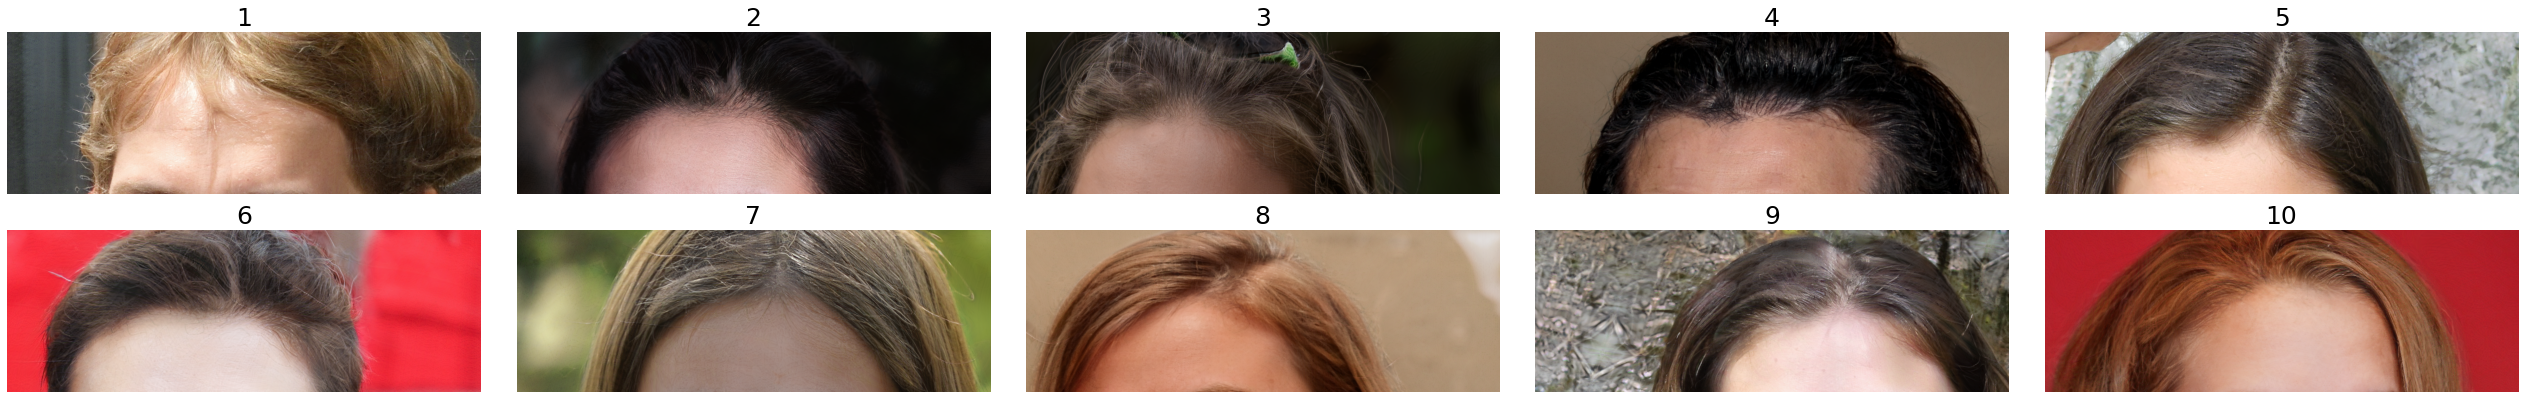

In [ ]:
#@title Run this cell to show the images of **Forehead**
#@markdown ---
display_grid(forehead)

In [ ]:
#@title Make selection from above of images of **Forehead**
forehead_selection =  8#@param {type:"number"}
forehead_selection -= 1

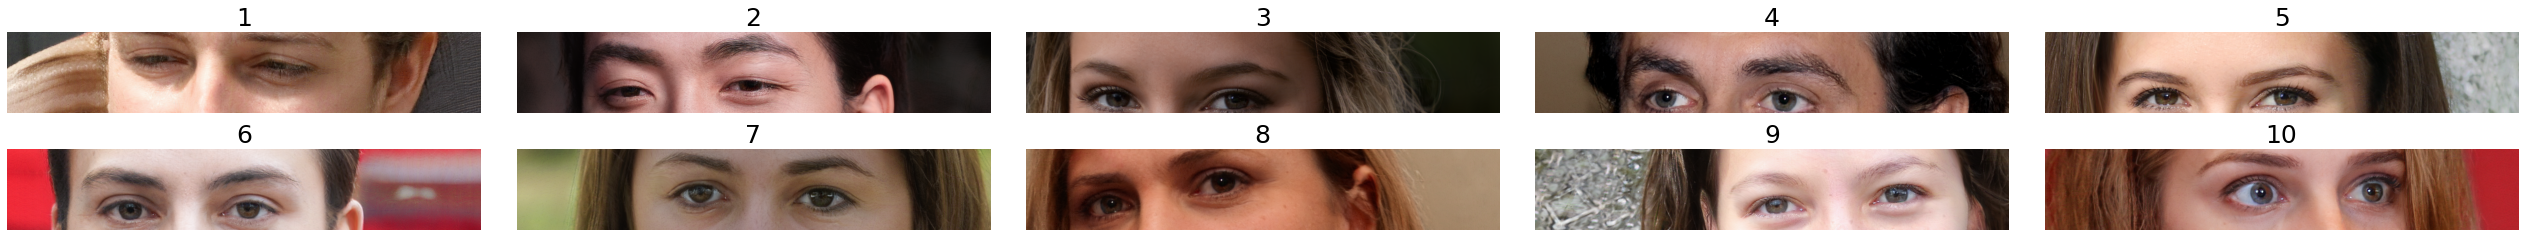

In [ ]:
#@title Run this cell to show the images of **Pair of Eyes**
#@markdown ---
display_grid(eyes)

In [ ]:
#@title Make selection from above of images of **Pair of Eyes**
eyes_selection =  2#@param {type:"number"}
eyes_selection -= 1

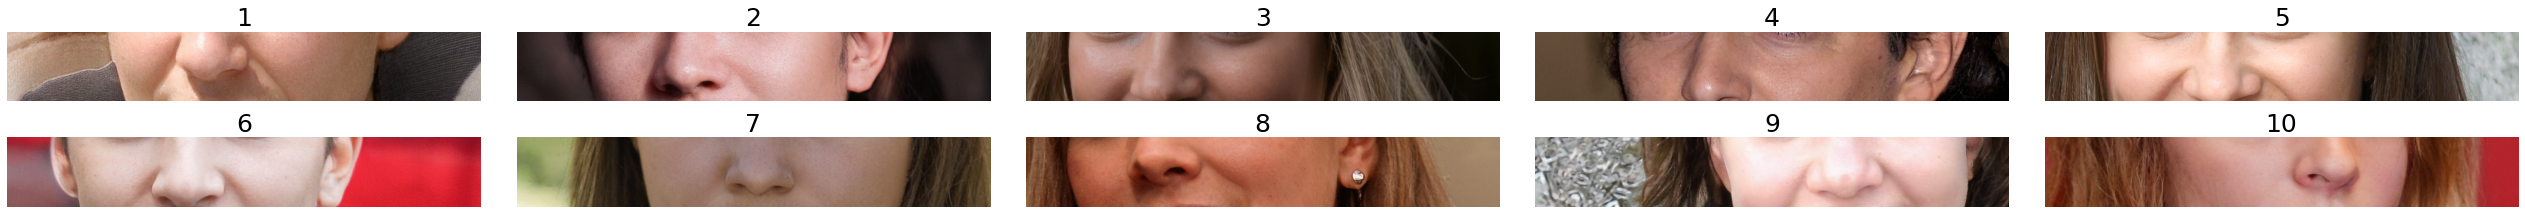

In [ ]:
#@title Run this cell to show the images of **Nose**
#@markdown ---
display_grid(nose)

In [ ]:
#@title Make selection from above of images of **Nose**
nose_selection =  5#@param {type:"number"}
nose_selection -= 1

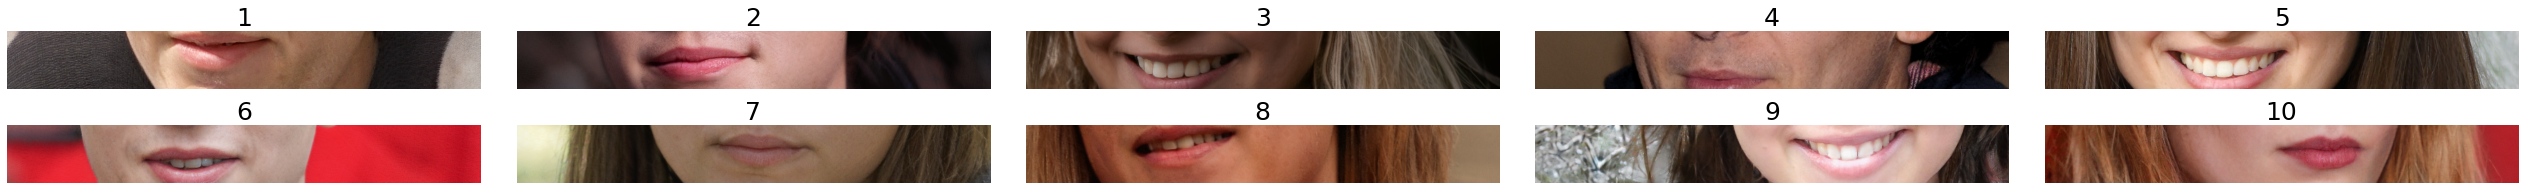

In [ ]:
#@title Run this cell to show the images of **Mouth**
#@markdown ---
display_grid(mouth)

In [ ]:
#@title Make selection from above of images of **Mouth**
mouth_selection =  6#@param {type:"number"}
mouth_selection -= 1

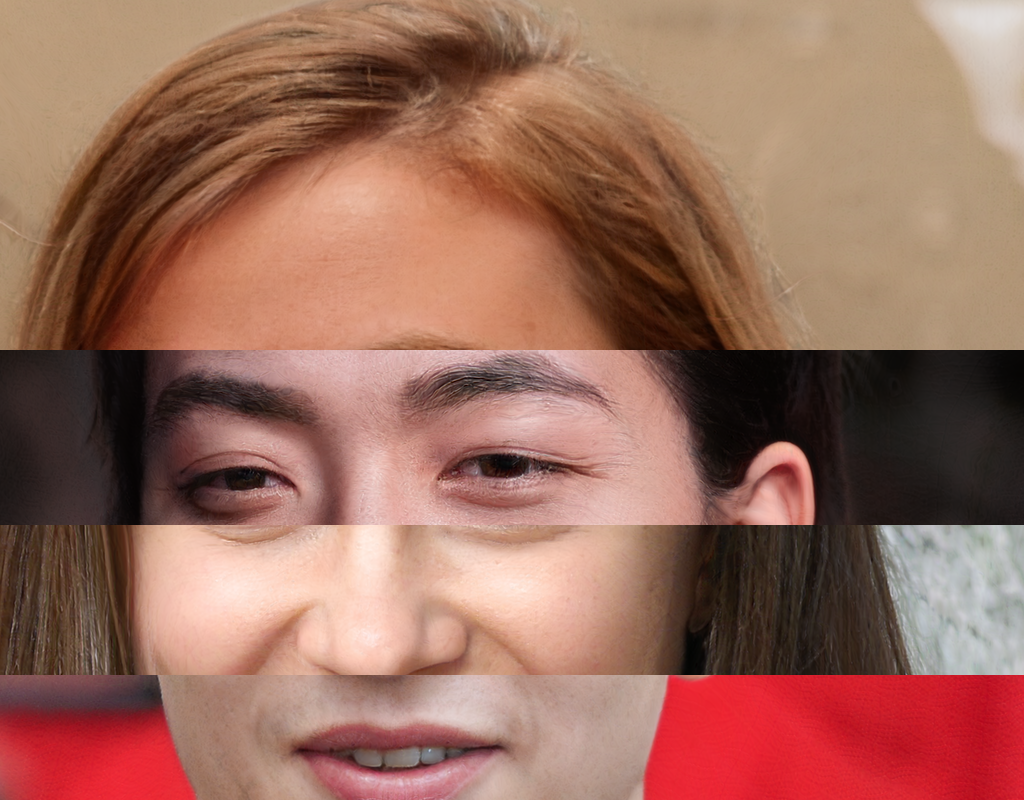

In [ ]:
#@title  #**See the Generated Face**
#@markdown ---
def merge_images(f, e, n, m):
    face = Image.new('RGB', (1024, f.height+e.height+n.height+m.height))
    face.paste(f, (0, 0))
    face.paste(e, (0, f.height))
    face.paste(n, (0, f.height+e.height))
    face.paste(m, (0, f.height+e.height+n.height))
    return face

created_face = merge_images(forehead[forehead_selection], eyes[eyes_selection], nose[nose_selection], mouth[mouth_selection])

display(created_face)

(-0.5, 1023.5, 799.5, -0.5)

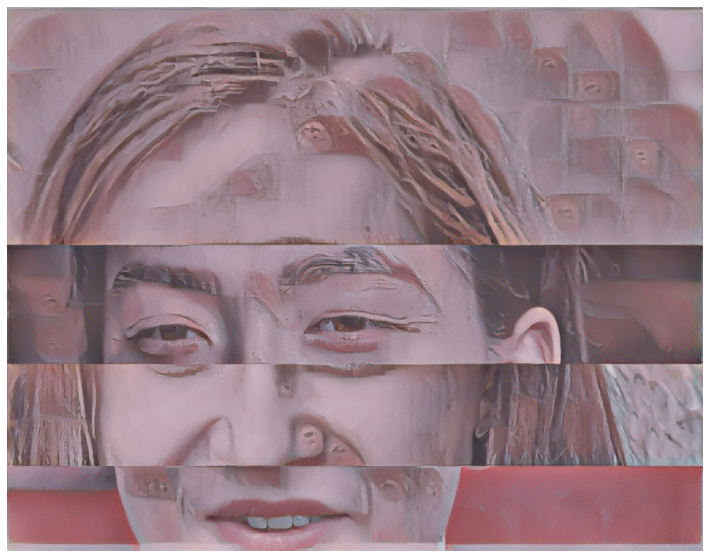

In [ ]:
#@title #**See the Sketch!**
#@markdown ---
import keras
import tensorflow as tf
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

face_np = keras.preprocessing.image.img_to_array(created_face)

c_img = np.expand_dims(face_np, axis=0)/255

stylized_image = hub_model(tf.constant(c_img), tf.constant(c_img))[0]

_, cell = plt.subplots(1,1, figsize=(30,10))
cell.imshow(stylized_image[0])
cell.axis('off')

## **Additionally, as I gave an attempt to Style Transfer with skin-tone. But the output is not as I expected it to be. It goes as follows:**

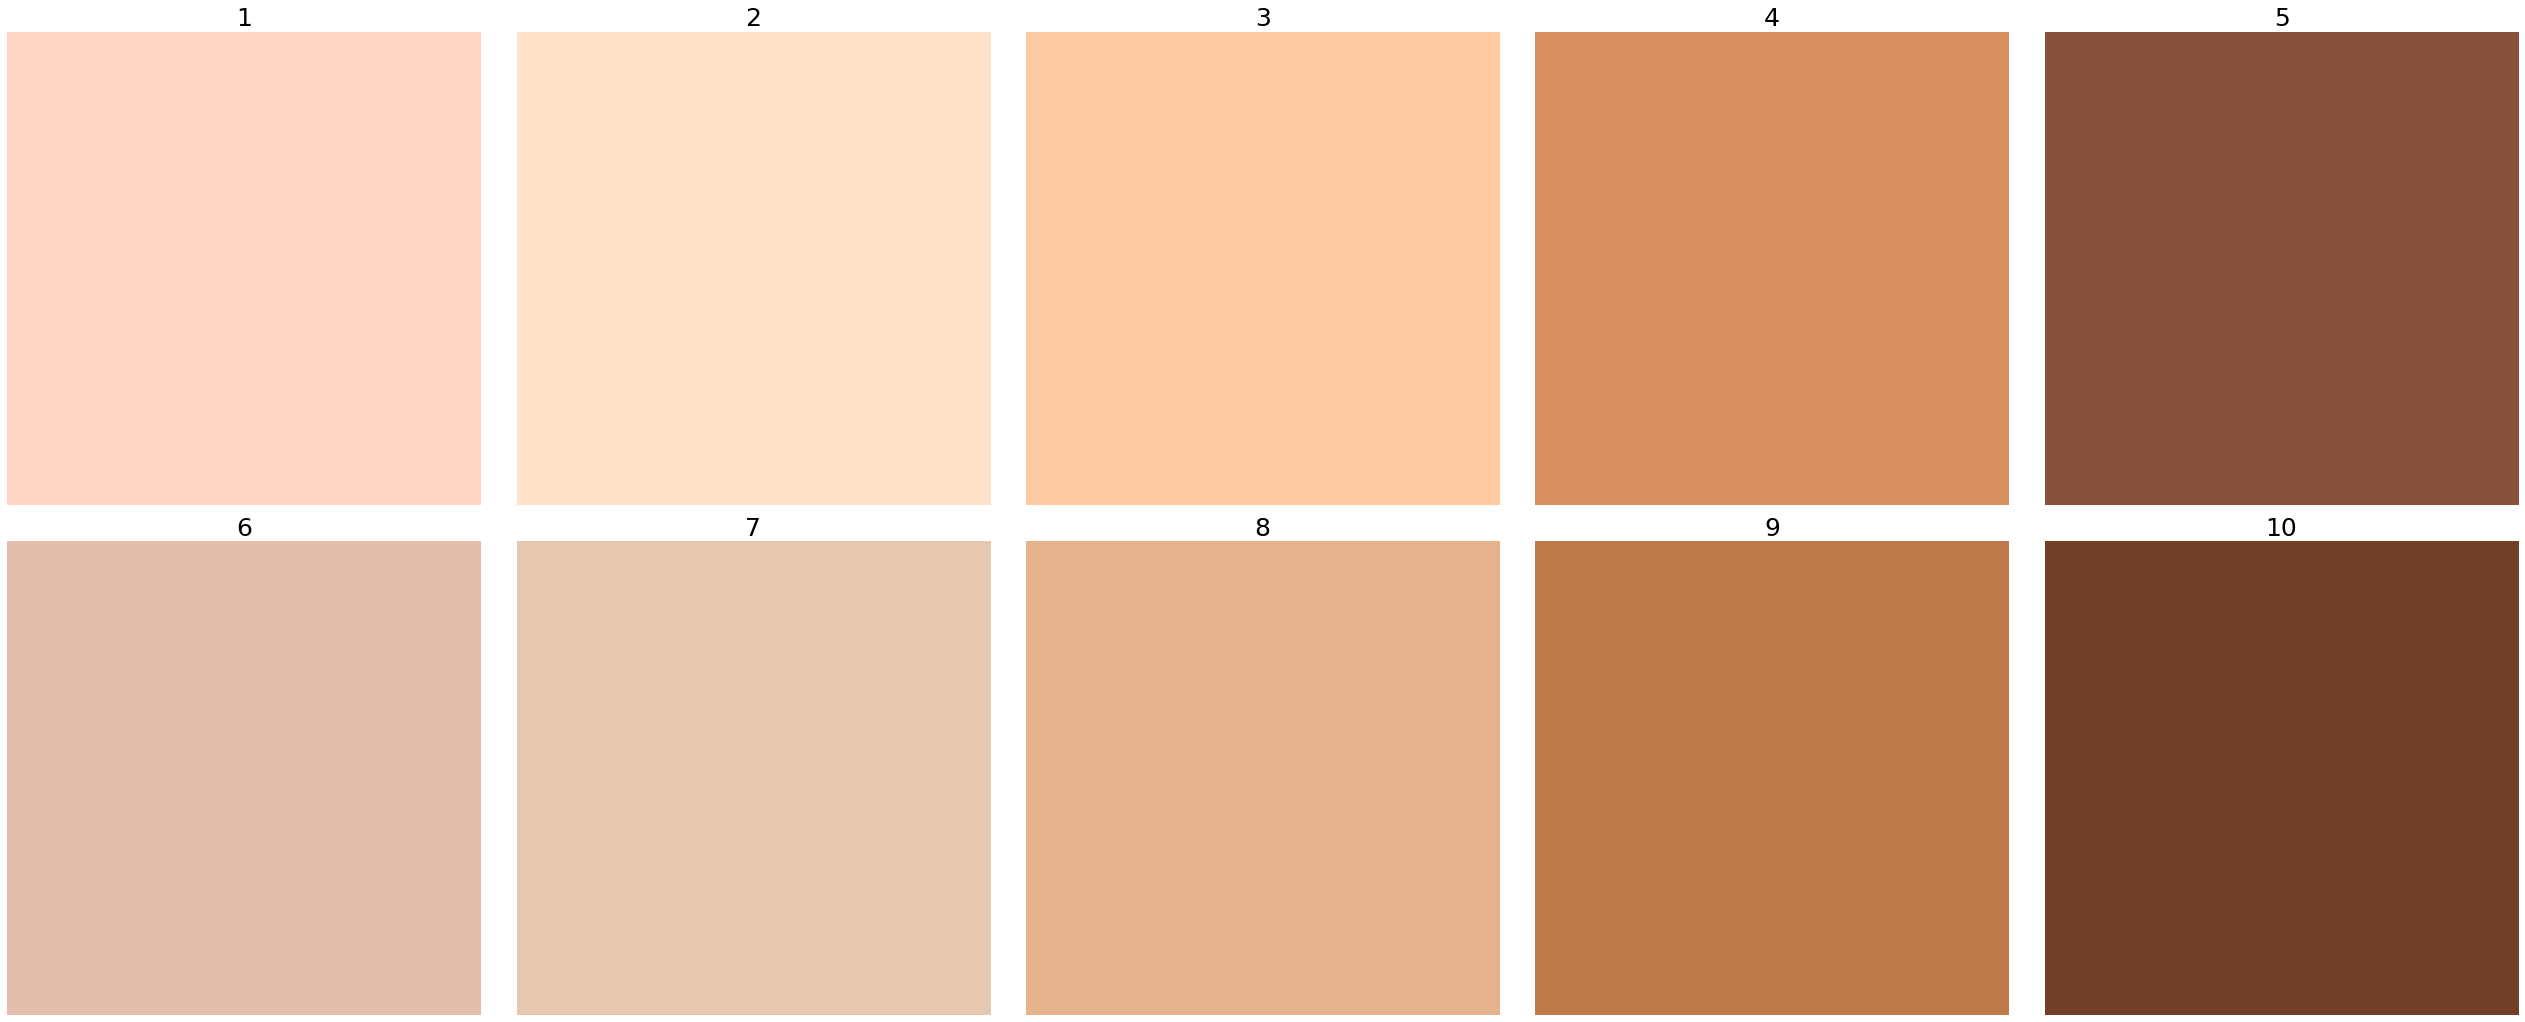

In [ ]:
#@title Showing **Skin-tones**
skin_tone = []
color_pallete = [(255, 214, 197), (255, 226, 201), (255, 203, 163), (216, 144, 95), (136, 81, 58), (228, 189, 173), (230, 200, 176), (231, 179, 141), (190, 121, 74), (	115, 62, 38)]
for i in color_pallete:
  skin_tone.append(Image.new(mode = "RGB", size = (1024, 1024), color = i))


display_grid(skin_tone)

In [ ]:
skin_selection =  5#@param {type:"number"}
skin_selection -= 1

skin = skin_tone[skin_selection]

(-0.5, 1023.5, 799.5, -0.5)

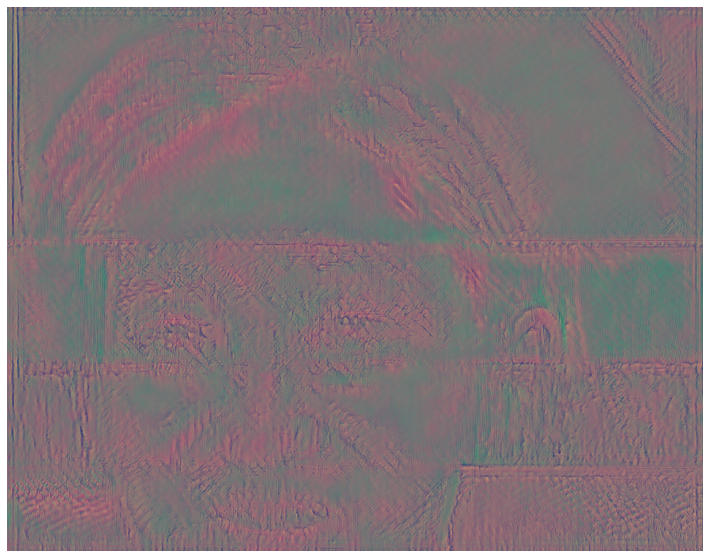

In [ ]:
#@title **See the Face with change of Skin-tone**

skin_np = keras.preprocessing.image.img_to_array(skin)

s_img = np.expand_dims(skin_np, axis=0)/255

withcolor_image = hub_model(tf.constant(c_img), tf.constant(s_img))[0]

_, cell = plt.subplots(1,1, figsize=(30,10))
cell.imshow(withcolor_image[0])
cell.axis('off')

## **Credits:**

This work is derived from previous work of [nshepperd](https://twitter.com/nshepperd1) (https://github.com/nshepperd), and later edited by Eugenio Herrera (https://github.com/ouhenio).

----